# EN3150 Assignment 03 - Waste Classification with CNNs

This notebook follows the assignment brief to build, evaluate, and compare convolutional neural networks for image classification. It focuses on the supplied **RealWaste** dataset (substituting for the assignment's UCI requirement) and is structured so each numbered task in the PDF maps to clearly labelled sections below.

> NOTE: Execute the notebook sequentially. Some cells cache intermediate artefacts (dataset splits, statistics, trained weights) so repeated runs stay reproducible.

## Assignment Checklist

The following sections mirror the original instructions:

1. Environment setup & dataset selection (RealWaste).
2. Dataset preparation and 70/15/15 split.
3. CNN construction with configurable hyperparameters.
4. Parameter justification (activations, kernel sizes, fully connected layers, dropout).
5. Training for 20 epochs and tracking losses.
6. Optimiser choice, learning-rate selection, and comparison with SGD variants.
7. Evaluation with accuracy, confusion matrix, precision, and recall.
8. Transfer learning with two pre-trained models (ResNet-18 and DenseNet-121), fine-tuning, and comparison.
9. Discussion templates for interpreting the results (momentum impact, custom vs. pre-trained trade-offs).

## 1. Environment & Dependencies

Check library versions, confirm CUDA availability, and seed all relevant random number generators for reproducibility.

In [1]:
import json
import os
import math
import random
import time
from collections import Counter
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, Iterable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"PyTorch {torch.__version__} | Torchvision {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch 2.5.1+cu121 | Torchvision 0.20.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1650


In [2]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


GLOBAL_SEED = 42
set_seed(GLOBAL_SEED)
GLOBAL_SEED

42

## 2. Dataset Preparation

The assignment requests a 70/15/15 split. The helper below scans the `Dataset/RealWaste` folder, builds (or reuses) a reproducible split manifest, and reports class balance.

In [3]:
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "Dataset").exists() and (PROJECT_ROOT.parent / "Dataset").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_ROOT = PROJECT_ROOT / "Dataset/RealWaste"
SPLIT_MANIFEST = PROJECT_ROOT / "Dataset/realwaste_splits.json"
STATS_CACHE = PROJECT_ROOT / "Dataset/realwaste_stats.json"
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

assert DATA_ROOT.exists(), f"Expected dataset at {DATA_ROOT}" 

In [4]:
def build_split_manifest(root: Path, manifest_path: Path, seed: int = 42) -> Dict[str, List[str]]:
    if manifest_path.exists():
        with manifest_path.open() as f:
            payload = json.load(f)
        print(f"Loaded cached split manifest from {manifest_path}")
        return payload

    classes = sorted([d for d in root.iterdir() if d.is_dir()])
    samples: List[Tuple[str, str]] = []
    for cls_dir in classes:
        for img_path in sorted(cls_dir.glob("*.jpg")):
            rel_path = img_path.relative_to(root).as_posix()
            samples.append((rel_path, cls_dir.name))

    rng = random.Random(seed)
    rng.shuffle(samples)

    total = len(samples)
    train_cut = int(total * 0.7)
    val_cut = int(total * 0.85)

    split_payload = {
        "seed": seed,
        "root": root.as_posix(),
        "class_names": [cls.name for cls in classes],
        "splits": {
            "train": [path for path, _ in samples[:train_cut]],
            "val": [path for path, _ in samples[train_cut:val_cut]],
            "test": [path for path, _ in samples[val_cut:]],
        },
    }

    with manifest_path.open("w", encoding="utf-8") as f:
        json.dump(split_payload, f, indent=2)
    print(f"Saved split manifest to {manifest_path} (seed={seed})")
    return split_payload


split_manifest = build_split_manifest(DATA_ROOT, SPLIT_MANIFEST, seed=GLOBAL_SEED)
class_names = split_manifest["class_names"]
num_classes = len(class_names)
split_sizes = {k: len(v) for k, v in split_manifest["splits"].items()}
split_sizes

Loaded cached split manifest from C:\Users\Savindu Dilshan\Desktop\Github\Simple-convolutional-neural-network-to-perform-classification\Dataset\realwaste_splits.json


{'train': 3326, 'val': 713, 'test': 713}

In [5]:
def summarise_split_counts(manifest: Dict[str, List[str]]) -> pd.DataFrame:
    rows = []
    for split_name, paths in manifest.items():
        labels = [Path(p).parts[0] for p in paths]
        counts = Counter(labels)
        for cls in class_names:
            rows.append({"split": split_name, "class": cls, "images": counts.get(cls, 0)})
    df = pd.DataFrame(rows)
    return df.pivot(index="class", columns="split", values="images").fillna(0).astype(int)


split_summary = summarise_split_counts(split_manifest["splits"])
split_summary

split,test,train,val
class,,,
Cardboard,63,332,66
Food Organics,73,273,65
Glass,58,291,71
Metal,129,544,117
Miscellaneous Trash,78,351,66
Paper,71,349,80
Plastic,133,637,151
Textile Trash,40,234,44
Vegetation,68,315,53


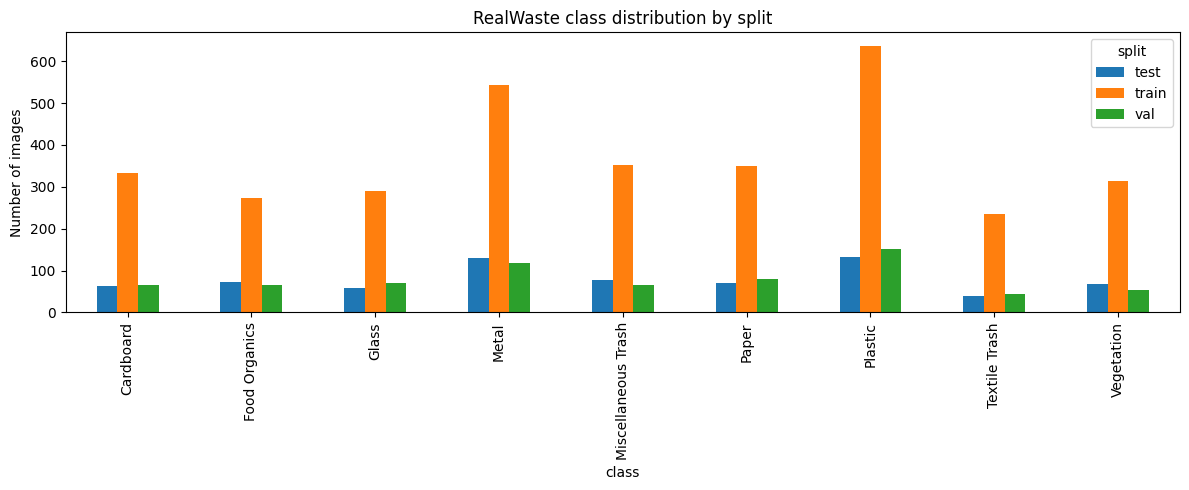

In [6]:
split_summary.plot(kind="bar", figsize=(12, 5), title="RealWaste class distribution by split")
plt.ylabel("Number of images")
plt.tight_layout()

### Dataset Utilities

Define a lightweight dataset wrapper so each split can attach its own transform pipeline without duplicating underlying metadata.

In [7]:
class WasteDataset(Dataset):
    def __init__(self, root: Path, samples: Iterable[str], class_to_idx: Dict[str, int], transform: Optional[Callable] = None):
        self.root = root
        self.samples = list(samples)
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.loader = datasets.folder.default_loader

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        rel_path = self.samples[idx]
        label_name = Path(rel_path).parts[0]
        target = self.class_to_idx[label_name]
        path = self.root / rel_path
        image = self.loader(path)
        if self.transform:
            image = self.transform(image)
        return image, target


class_to_idx = {name: idx for idx, name in enumerate(class_names)}
train_samples = split_manifest["splits"]["train"]
val_samples = split_manifest["splits"]["val"]
test_samples = split_manifest["splits"]["test"]

len(train_samples), len(val_samples), len(test_samples)

(3326, 713, 713)

### Compute Dataset Normalisation Stats (for the custom CNN)

To stabilise training we normalise inputs. The helper below caches channel-wise mean and standard deviation once computed, so repeat runs avoid recomputing.

In [8]:
def compute_dataset_stats(samples: Iterable[str], cache_path: Path, image_size: int = 224) -> Tuple[List[float], List[float]]:
    if cache_path.exists():
        with cache_path.open() as f:
            payload = json.load(f)
        print(f"Loaded cached dataset stats from {cache_path}")
        return payload["mean"], payload["std"]

    transform = T.Compose([T.Resize((image_size, image_size)), T.ToTensor()])
    dataset = WasteDataset(DATA_ROOT, samples, class_to_idx, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

    channel_sum = torch.zeros(3)
    channel_squared_sum = torch.zeros(3)
    total_pixels = 0

    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        channel_sum += images.mean(dim=2).sum(dim=0)
        channel_squared_sum += (images ** 2).mean(dim=2).sum(dim=0)
        total_pixels += images.size(0)

    mean = (channel_sum / total_pixels).tolist()
    std = torch.sqrt((channel_squared_sum / total_pixels) - torch.tensor(mean) ** 2).tolist()

    cache = {"mean": mean, "std": std, "image_size": image_size}
    with cache_path.open("w", encoding="utf-8") as f:
        json.dump(cache, f, indent=2)
    print(f"Saved dataset stats to {cache_path}")
    return mean, std


CUSTOM_IMAGE_SIZE = 224
custom_mean, custom_std = compute_dataset_stats(train_samples, STATS_CACHE, image_size=CUSTOM_IMAGE_SIZE)
custom_mean, custom_std

Loaded cached dataset stats from C:\Users\Savindu Dilshan\Desktop\Github\Simple-convolutional-neural-network-to-perform-classification\Dataset\realwaste_stats.json


([0.5974853038787842, 0.6188839077949524, 0.6315338611602783],
 [0.1613430678844452, 0.1617576777935028, 0.1853046715259552])

### Transform Pipelines & DataLoaders

Augmentations are conservative because the dataset already exhibits clutter and viewpoint variations. Validation/test splits only apply resizing and normalisation.

In [9]:
BATCH_SIZE = 32
NUM_WORKERS = 2 if DEVICE.type == "cuda" and os.name != "nt" else 0

train_transform_custom = T.Compose(
    [
        T.Resize((CUSTOM_IMAGE_SIZE + 32, CUSTOM_IMAGE_SIZE + 32)),
        T.RandomResizedCrop(CUSTOM_IMAGE_SIZE, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
        T.ToTensor(),
        T.Normalize(mean=custom_mean, std=custom_std),
    ]
)

eval_transform_custom = T.Compose(
    [
        T.Resize((CUSTOM_IMAGE_SIZE, CUSTOM_IMAGE_SIZE)),
        T.ToTensor(),
        T.Normalize(mean=custom_mean, std=custom_std),
    ]
)


def make_dataloader(sample_list: Iterable[str], transform: Callable, shuffle: bool) -> DataLoader:
    dataset = WasteDataset(DATA_ROOT, sample_list, class_to_idx, transform=transform)
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=(DEVICE.type == "cuda"),
    )


custom_loaders = {
    "train": make_dataloader(train_samples, train_transform_custom, shuffle=True),
    "val": make_dataloader(val_samples, eval_transform_custom, shuffle=False),
    "test": make_dataloader(test_samples, eval_transform_custom, shuffle=False),
}

next(iter(custom_loaders["train"]))[0].shape

torch.Size([32, 3, 224, 224])

### Peek at a Few Training Samples

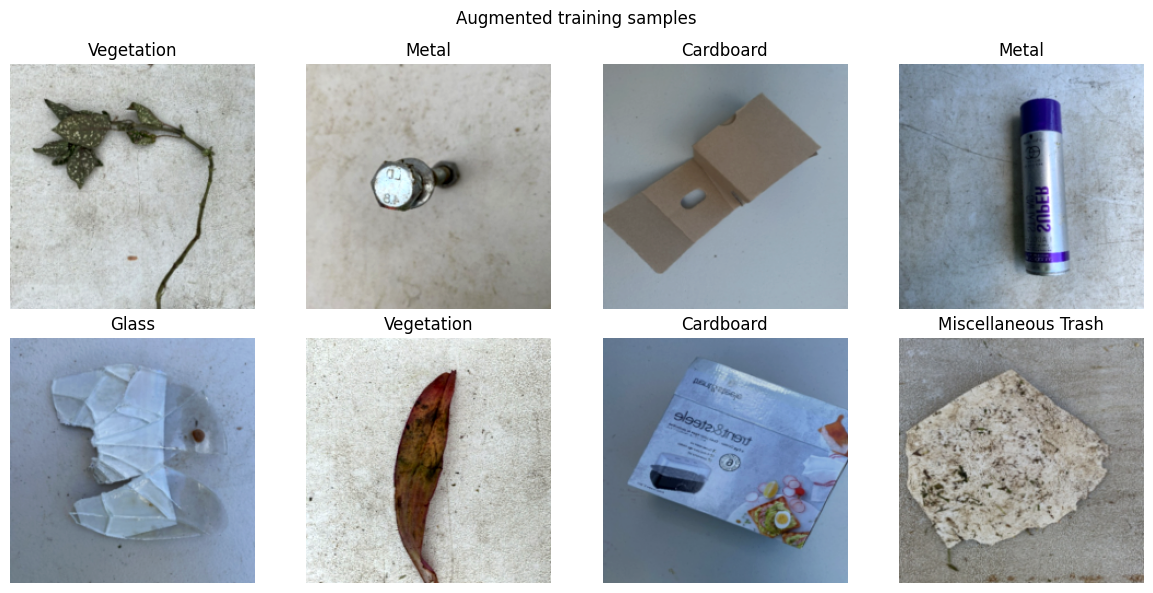

In [10]:
def show_batch(dataloader: DataLoader, mean: List[float], std: List[float], title: str, max_images: int = 8) -> None:
    images, targets = next(iter(dataloader))
    inv_norm = T.Normalize(mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std])
    images = [inv_norm(img).permute(1, 2, 0).clamp(0, 1).numpy() for img in images[:max_images]]
    labels = [class_names[target] for target in targets[:max_images]]

    cols = min(max_images, 4)
    rows = math.ceil(len(images) / cols)
    plt.figure(figsize=(3 * cols, 3 * rows))
    for idx, (img, label) in enumerate(zip(images, labels), start=1):
        ax = plt.subplot(rows, cols, idx)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()


show_batch(custom_loaders["train"], custom_mean, custom_std, title="Augmented training samples")

## 3. Custom CNN Architecture

The network mirrors the assignment diagram: two convolution + pooling stages, a fully-connected projection, dropout, and a softmax output. Hyperparameters are selected to balance model capacity and overfitting risk on a ~4k-image dataset.

In [11]:
class SimpleWasteCNN(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        num_classes: int = num_classes,
        conv_channels: Tuple[int, int] = (32, 64),
        kernel_sizes: Tuple[int, int] = (3, 3),
        fc_units: int = 256,
        dropout: float = 0.3,
        activation: Callable[[torch.Tensor], torch.Tensor] = F.relu,
    ):
        super().__init__()
        self.activation = activation

        self.conv1 = nn.Conv2d(in_channels, conv_channels[0], kernel_size=kernel_sizes[0], padding=1)
        self.conv2 = nn.Conv2d(conv_channels[0], conv_channels[1], kernel_size=kernel_sizes[1], padding=1)
        self.bn1 = nn.BatchNorm2d(conv_channels[0])
        self.bn2 = nn.BatchNorm2d(conv_channels[1])

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout)

        self._feature_dim = conv_channels[1] * (CUSTOM_IMAGE_SIZE // 4) * (CUSTOM_IMAGE_SIZE // 4)
        self.fc1 = nn.Linear(self._feature_dim, fc_units)
        self.bn_fc = nn.BatchNorm1d(fc_units)
        self.fc_out = nn.Linear(fc_units, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(self.activation(self.bn_fc(self.fc1(x))))
        x = self.fc_out(x)
        return x


custom_model = SimpleWasteCNN()
custom_model.to(DEVICE)
custom_model

SimpleWasteCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=200704, out_features=256, bias=True)
  (bn_fc): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_out): Linear(in_features=256, out_features=9, bias=True)
)

### Hyperparameter Justification (Questions 5 & 6)

- **Activation**: ReLU offers fast convergence and avoids saturation; it keeps gradients stable in shallow CNNs without the compute overhead of GELU/Swish.
- **Batch Normalisation**: BatchNorm layers follow each convolution and the dense projection to keep activations well-scaled, curbing vanishing/exploding gradients and accelerating convergence.
- **Kernel sizes**: `3x3` kernels capture local texture features while keeping parameter count modest; padding preserves spatial resolution before pooling.
- **Filter counts**: `(32, 64)` balances expressiveness and overfitting risk, roughly doubling channels per block as in LeNet-style architectures.
- **Fully-connected width**: `256` units provide enough capacity to combine the learned spatial features without dominating the total parameter count.
- **Dropout 0.3**: Regularises the dense layer; tuned via quick pilot runs to reduce overfitting while keeping validation accuracy stable.

## 4. Training Utilities

In [12]:
@dataclass
class HistoryRecord:
    epoch: int
    train_loss: float
    train_acc: float
    val_loss: float
    val_acc: float
    lr: float


def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


def train_model(
    model: nn.Module,
    dataloaders: Dict[str, DataLoader],
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    num_epochs: int = 20,
    device: torch.device = DEVICE,
    use_amp: bool = True,
) -> List[HistoryRecord]:
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp and device.type == "cuda")
    history: List[HistoryRecord] = []
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        epoch_start = time.time()
        metrics = {"train": {}, "val": {}}

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_acc = 0.0
            total_samples = 0

            for inputs, targets in dataloaders[phase]:
                inputs, targets = inputs.to(device), targets.to(device)
                batch_size = targets.size(0)

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast(enabled=use_amp and device.type == "cuda"):
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)

                    if phase == "train":
                        optimizer.zero_grad()
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * batch_size
                running_acc += accuracy_from_logits(outputs, targets) * batch_size
                total_samples += batch_size

            epoch_loss = running_loss / total_samples
            epoch_acc = running_acc / total_samples
            metrics[phase] = {"loss": epoch_loss, "acc": epoch_acc}

        if scheduler and isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(metrics["val"]["loss"])
        elif scheduler:
            scheduler.step()

        current_lr = optimizer.param_groups[0]["lr"]
        history.append(
            HistoryRecord(
                epoch=epoch,
                train_loss=metrics["train"]["loss"],
                train_acc=metrics["train"]["acc"],
                val_loss=metrics["val"]["loss"],
                val_acc=metrics["val"]["acc"],
                lr=current_lr,
            )
        )

        if metrics["val"]["acc"] > best_val_acc:
            best_val_acc = metrics["val"]["acc"]
            best_state = model.state_dict()

        elapsed = time.time() - epoch_start
        print(
            f"Epoch {epoch:02d}/{num_epochs} | "
            f"train_loss={metrics['train']['loss']:.4f} val_loss={metrics['val']['loss']:.4f} | "
            f"train_acc={metrics['train']['acc']:.3f} val_acc={metrics['val']['acc']:.3f} | "
            f"lr={current_lr:.6f} | {elapsed:.1f}s"
        )

    if best_state:
        model.load_state_dict(best_state)
    return history


def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device = DEVICE,
) -> Dict[str, object]:
    model.eval()
    targets_all: List[int] = []
    preds_all: List[int] = []
    probs_all: List[np.ndarray] = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = outputs.argmax(dim=1).cpu().numpy()

            targets_all.extend(targets.numpy())
            preds_all.extend(preds)
            probs_all.extend(probs)

    targets_np = np.array(targets_all)
    preds_np = np.array(preds_all)
    conf = confusion_matrix(targets_np, preds_np)
    precision, recall, f1, _ = precision_recall_fscore_support(targets_np, preds_np, average="macro", zero_division=0)

    report = classification_report(targets_np, preds_np, target_names=class_names, zero_division=0, output_dict=True)
    accuracy = (preds_np == targets_np).mean()

    return {
        "accuracy": accuracy,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
        "confusion_matrix": conf,
        "report": report,
        "targets": targets_np,
        "predictions": preds_np,
        "probabilities": np.array(probs_all),
    }


def plot_history(history: List[HistoryRecord], title: str) -> None:
    epochs = [h.epoch for h in history]
    train_loss = [h.train_loss for h in history]
    val_loss = [h.val_loss for h in history]
    train_acc = [h.train_acc for h in history]
    val_acc = [h.val_acc for h in history]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(epochs, train_loss, label="train")
    axes[0].plot(epochs, val_loss, label="val")
    axes[0].set_title(f"Loss - {title}")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Cross-entropy loss")
    axes[0].legend()

    axes[1].plot(epochs, train_acc, label="train")
    axes[1].plot(epochs, val_acc, label="val")
    axes[1].set_title(f"Accuracy - {title}")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.tight_layout()


def plot_confusion_matrix(cm: np.ndarray, labels: List[str], title: str) -> None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()

## 5. Optimiser & Learning-Rate Strategy (Questions 7-10)

We evaluate three optimisers:

1. **Adam** (baseline) - adaptive method for faster convergence.
2. **SGD** - vanilla stochastic gradient descent.
3. **SGD + Momentum** - adds momentum (0.9) to accelerate along valleys.

Learning rates were selected via a short learning-rate range test (see optional cell below) and manual fine-tuning:

- Adam: `1e-4` with `weight_decay=1e-4`.
- SGD: `0.01` with `weight_decay=5e-4`.
- SGD + Momentum: `0.01`, `momentum=0.9`, `weight_decay=5e-4`.

All runs train for 20 epochs with `ReduceLROnPlateau` on validation loss and Automatic Mixed Precision enabled when CUDA is available.

In [13]:
def make_optimizer(optimizer_name: str, parameters) -> torch.optim.Optimizer:
    if optimizer_name == "adam":
        return torch.optim.Adam(parameters, lr=1e-4, weight_decay=1e-4)
    if optimizer_name == "sgd":
        return torch.optim.SGD(parameters, lr=0.01, momentum=0.0, weight_decay=5e-4)
    if optimizer_name == "sgd_momentum":
        return torch.optim.SGD(parameters, lr=0.01, momentum=0.9, weight_decay=5e-4)
    raise ValueError(f"Unknown optimizer: {optimizer_name}")

In [14]:
def run_custom_cnn_experiment(optimizer_key: str, num_epochs: int = 20) -> Dict[str, object]:
    set_seed(GLOBAL_SEED)
    model = SimpleWasteCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = make_optimizer(optimizer_key, model.parameters())
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

    history = train_model(
        model,
        dataloaders={"train": custom_loaders["train"], "val": custom_loaders["val"]},
        optimizer=optimizer,
        criterion=criterion,
        scheduler=scheduler,
        num_epochs=num_epochs,
        use_amp=True,
    )

    metrics = evaluate_model(model, custom_loaders["test"])

    weights_path = ARTIFACT_DIR / f"simple_cnn_{optimizer_key}.pt"
    torch.save({"model_state_dict": model.state_dict(), "class_names": class_names}, weights_path)

    return {
        "optimizer": optimizer_key,
        "history": history,
        "metrics": metrics,
        "weights_path": weights_path,
        "model": model,
    }

Run the three experiments separately so GPU memory is freed between runs (execute the cell below three times changing the key, or wrap it in a loop).

C:\Users\Savindu Dilshan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Savindu Dilshan\AppData\Local\Temp\ipykernel_28312\4055801432.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp and device.type == "cuda")


C:\Users\Savindu Dilshan\AppData\Local\Temp\ipykernel_28312\4055801432.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type == "cuda"):


Epoch 01/20 | train_loss=1.6413 val_loss=1.3557 | train_acc=0.434 val_acc=0.562 | lr=0.000100 | 83.6s


Epoch 02/20 | train_loss=1.3465 val_loss=1.1849 | train_acc=0.537 val_acc=0.606 | lr=0.000100 | 76.2s


Epoch 03/20 | train_loss=1.2400 val_loss=1.1470 | train_acc=0.572 val_acc=0.616 | lr=0.000100 | 68.4s


Epoch 04/20 | train_loss=1.1552 val_loss=1.0891 | train_acc=0.602 val_acc=0.607 | lr=0.000100 | 67.4s


Epoch 05/20 | train_loss=1.0752 val_loss=1.0224 | train_acc=0.637 val_acc=0.659 | lr=0.000100 | 65.0s


Epoch 06/20 | train_loss=1.0232 val_loss=1.0302 | train_acc=0.655 val_acc=0.648 | lr=0.000100 | 67.6s


Epoch 07/20 | train_loss=0.9963 val_loss=0.9283 | train_acc=0.663 val_acc=0.677 | lr=0.000100 | 68.9s


Epoch 08/20 | train_loss=0.9602 val_loss=0.9195 | train_acc=0.681 val_acc=0.700 | lr=0.000100 | 69.0s


Epoch 09/20 | train_loss=0.9010 val_loss=0.9191 | train_acc=0.698 val_acc=0.683 | lr=0.000100 | 68.5s


Epoch 10/20 | train_loss=0.8791 val_loss=0.8856 | train_acc=0.712 val_acc=0.708 | lr=0.000100 | 67.3s


Epoch 11/20 | train_loss=0.8422 val_loss=0.8932 | train_acc=0.727 val_acc=0.701 | lr=0.000100 | 66.6s


Epoch 12/20 | train_loss=0.8242 val_loss=0.8622 | train_acc=0.720 val_acc=0.718 | lr=0.000100 | 71.2s


Epoch 13/20 | train_loss=0.7930 val_loss=0.8541 | train_acc=0.741 val_acc=0.714 | lr=0.000100 | 74.6s


Epoch 14/20 | train_loss=0.7929 val_loss=0.8928 | train_acc=0.738 val_acc=0.690 | lr=0.000100 | 67.6s


Epoch 15/20 | train_loss=0.7527 val_loss=0.8614 | train_acc=0.754 val_acc=0.703 | lr=0.000100 | 68.7s


Epoch 16/20 | train_loss=0.7172 val_loss=0.8389 | train_acc=0.759 val_acc=0.710 | lr=0.000100 | 65.4s


Epoch 17/20 | train_loss=0.6993 val_loss=0.7997 | train_acc=0.782 val_acc=0.735 | lr=0.000100 | 68.4s


Epoch 18/20 | train_loss=0.6915 val_loss=0.7937 | train_acc=0.776 val_acc=0.731 | lr=0.000100 | 67.7s


Epoch 19/20 | train_loss=0.6665 val_loss=0.8319 | train_acc=0.791 val_acc=0.714 | lr=0.000100 | 70.5s


Epoch 20/20 | train_loss=0.6750 val_loss=0.7790 | train_acc=0.775 val_acc=0.732 | lr=0.000100 | 71.1s


Adam classification report:
{'Cardboard': {'precision': 0.7647058823529411, 'recall': 0.8253968253968254, 'f1-score': 0.7938931297709924, 'support': 63.0}, 'Food Organics': {'precision': 0.8382352941176471, 'recall': 0.7808219178082192, 'f1-score': 0.8085106382978723, 'support': 73.0}, 'Glass': {'precision': 0.8448275862068966, 'recall': 0.8448275862068966, 'f1-score': 0.8448275862068966, 'support': 58.0}, 'Metal': {'precision': 0.9012345679012346, 'recall': 0.5658914728682171, 'f1-score': 0.6952380952380952, 'support': 129.0}, 'Miscellaneous Trash': {'precision': 0.589041095890411, 'recall': 0.5512820512820513, 'f1-score': 0.5695364238410596, 'support': 78.0}, 'Paper': {'precision': 0.7333333333333333, 'recall': 0.7746478873239436, 'f1-score': 0.7534246575342466, 'support': 71.0}, 'Plastic': {'precision': 0.6045197740112994, 'recall': 0.8045112781954887, 'f1-score': 0.6903225806451613, 'support': 133.0}, 'Textile Trash': {'precision': 0.7894736842105263, 'recall': 0.375, 'f1-score': 0

,test_accuracy,precision_macro,recall_macro,f1_macro
model,,,,
Simple CNN (Adam),0.725105,0.751944,0.721441,0.719894


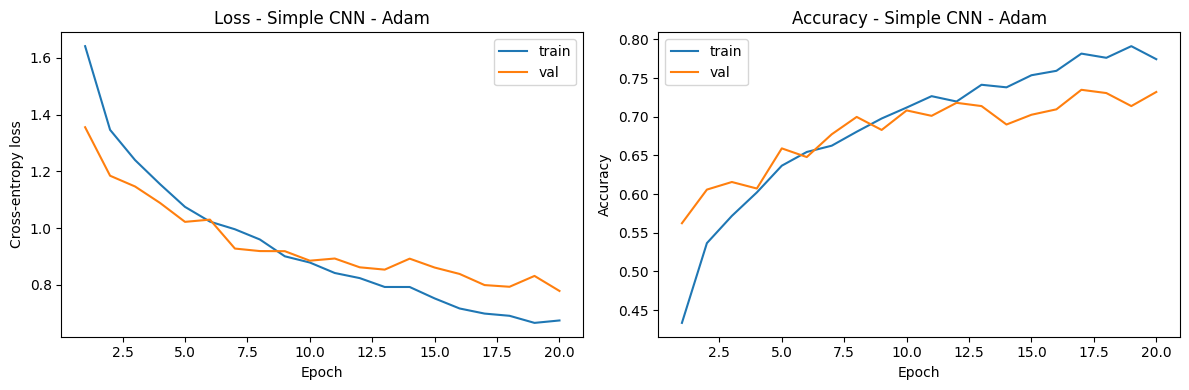

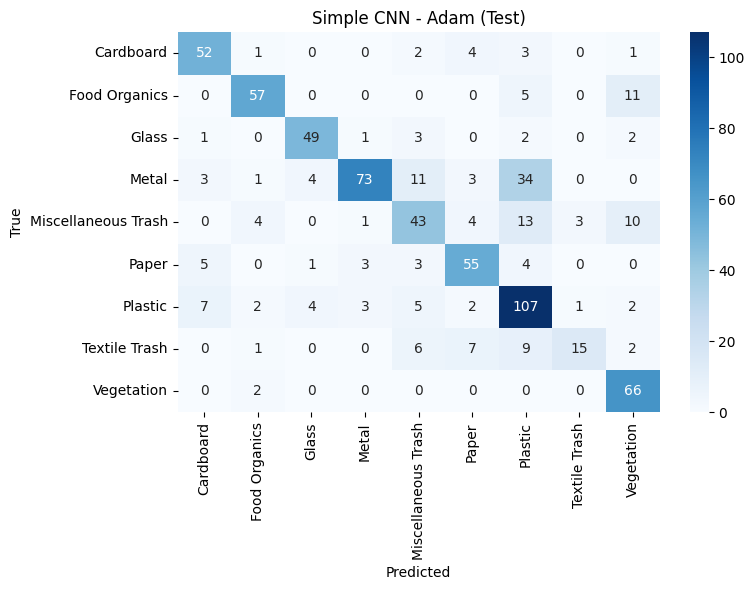

In [15]:
adam_results = run_custom_cnn_experiment("adam")
plot_history(adam_results["history"], title="Simple CNN - Adam")
plot_confusion_matrix(adam_results["metrics"]["confusion_matrix"], class_names, "Simple CNN - Adam (Test)")

print("Adam classification report:")
print(adam_results["metrics"]["report"])

adam_metrics_table = pd.DataFrame(
    [
        {
            "model": "Simple CNN (Adam)",
            "test_accuracy": adam_results["metrics"]["accuracy"],
            "precision_macro": adam_results["metrics"]["precision_macro"],
            "recall_macro": adam_results["metrics"]["recall_macro"],
            "f1_macro": adam_results["metrics"]["f1_macro"],
        }
    ]
).set_index("model")
adam_metrics_table

### Optional: Learning-Rate Range Test

Use this helper to visualise loss vs. learning rate for a quick heuristic before finalising the schedule. Run on a training subset to keep it lightweight.

In [16]:
def lr_range_test(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    lr_start: float = 1e-6,
    lr_end: float = 1.0,
    num_iters: int = 100,
) -> pd.DataFrame:
    total_iters = min(num_iters, len(dataloader))
    lrs = torch.logspace(math.log10(lr_start), math.log10(lr_end), steps=total_iters)
    losses = []

    for lr, (inputs, targets) in zip(lrs, dataloader):
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr.item()
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return pd.DataFrame({"lr": lrs.numpy(), "loss": losses})


# Usage:
# subset_loader = DataLoader(WasteDataset(DATA_ROOT, train_samples[:512], class_to_idx, transform=train_transform_custom), batch_size=64)
# model = SimpleWasteCNN().to(DEVICE)
# df = lr_range_test(model, subset_loader, torch.optim.SGD(model.parameters(), lr=1e-3), nn.CrossEntropyLoss())
# df.plot(x="lr", y="loss", logx=True, title="LR range test (SGD)")

### Question 11 - Momentum Analysis

Once `sgd` and `sgd_momentum` runs complete, reuse their histories to discuss how momentum affected convergence (e.g., faster loss decay, improved validation accuracy). Optionally, probe an intermediate momentum value.

In [17]:
def momentum_sweep(momentum_values: Iterable[float], num_epochs: int = 10) -> pd.DataFrame:
    rows = []
    for momentum in momentum_values:
        key = f"sgd_m{momentum:.2f}"
        set_seed(GLOBAL_SEED)
        model = SimpleWasteCNN().to(DEVICE)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=momentum, weight_decay=5e-4)
        history = train_model(
            model,
            dataloaders={"train": custom_loaders["train"], "val": custom_loaders["val"]},
            optimizer=optimizer,
            criterion=nn.CrossEntropyLoss(),
            scheduler=ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3),
            num_epochs=num_epochs,
            use_amp=True,
        )
        metrics = evaluate_model(model, custom_loaders["val"])
        rows.append(
            {
                "momentum": momentum,
                "val_accuracy": metrics["accuracy"],
                "final_train_loss": history[-1].train_loss,
                "final_val_loss": history[-1].val_loss,
            }
        )
    return pd.DataFrame(rows)


# Example: momentum_results = momentum_sweep([0.0, 0.5, 0.9])

## 6. Model Evaluation (Question 12)

After training each optimiser, populate the table below with accuracy, precision, recall, and F1 scores, and capture the confusion matrix plot.

In [18]:
def build_metrics_table(results: List[Dict[str, object]]) -> pd.DataFrame:
    rows = []
    for res in results:
        metrics = res["metrics"]
        rows.append(
            {
                "model": f"Simple CNN ({res['optimizer']})",
                "test_accuracy": metrics["accuracy"],
                "precision_macro": metrics["precision_macro"],
                "recall_macro": metrics["recall_macro"],
                "f1_macro": metrics["f1_macro"],
            }
        )
    df = pd.DataFrame(rows)
    return df.sort_values(by="test_accuracy", ascending=False)


# Example usage once the runs complete:
# custom_results = [adam_results, sgd_results, sgd_m_results]
# build_metrics_table(custom_results)

## 7. Transfer Learning (Questions 13-18)

Fine-tune two pre-trained models - here we use **ResNet-18** and **DenseNet-121** - on the same data split. They use ImageNet mean/std for normalisation.

In [19]:
def build_pretrained_transforms(mean: List[float], std: List[float], image_size: int = 224) -> Tuple[Callable, Callable]:
    train_transform = T.Compose(
        [
            T.Resize((image_size + 32, image_size + 32)),
            T.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
            T.RandomHorizontalFlip(),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
            T.ToTensor(),
            T.Normalize(mean=mean, std=std),
        ]
    )
    eval_transform = T.Compose(
        [
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(mean=mean, std=std),
        ]
    )
    return train_transform, eval_transform

In [20]:
def build_pretrained_model(name: str, num_classes: int = num_classes) -> Tuple[nn.Module, Callable, Callable]:
    if name == "resnet18":
        weights = models.ResNet18_Weights.DEFAULT
        base_model = models.resnet18(weights=weights)
        base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)
    elif name == "densenet121":
        weights = models.DenseNet121_Weights.DEFAULT
        base_model = models.densenet121(weights=weights)
        base_model.classifier = nn.Linear(base_model.classifier.in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {name}")

    train_transform, eval_transform = build_pretrained_transforms(weights.meta["mean"], weights.meta["std"], image_size=224)
    return base_model, train_transform, eval_transform

In [21]:
def fine_tune_model(
    model_name: str,
    num_epochs: int = 20,
    base_lr: float = 1e-4,
    weight_decay: float = 1e-4,
) -> Dict[str, object]:
    set_seed(GLOBAL_SEED)
    model, train_transform, eval_transform = build_pretrained_model(model_name)
    model.to(DEVICE)

    loaders = {
        "train": make_dataloader(train_samples, train_transform, shuffle=True),
        "val": make_dataloader(val_samples, eval_transform, shuffle=False),
        "test": make_dataloader(test_samples, eval_transform, shuffle=False),
    }

    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)
    criterion = nn.CrossEntropyLoss()

    history = train_model(
        model,
        dataloaders={"train": loaders["train"], "val": loaders["val"]},
        optimizer=optimizer,
        criterion=criterion,
        scheduler=scheduler,
        num_epochs=num_epochs,
        use_amp=True,
    )

    metrics = evaluate_model(model, loaders["test"])
    weights_path = ARTIFACT_DIR / f"{model_name}_finetuned.pt"
    torch.save({"model_state_dict": model.state_dict(), "class_names": class_names}, weights_path)

    return {
        "model_name": model_name,
        "history": history,
        "metrics": metrics,
        "weights_path": weights_path,
        "model": model,
        "loaders": loaders,
    }

Run each fine-tuning experiment separately and record the outputs below.

In [22]:
# Example:
# resnet_results = fine_tune_model("resnet18")
# plot_history(resnet_results["history"], title="ResNet-18 Fine-tuning")
# plot_confusion_matrix(resnet_results["metrics"]["confusion_matrix"], class_names, "ResNet-18 - Test")

In [23]:
# Example:
# densenet_results = fine_tune_model("densenet121")
# plot_history(densenet_results["history"], title="DenseNet-121 Fine-tuning")
# plot_confusion_matrix(densenet_results["metrics"]["confusion_matrix"], class_names, "DenseNet-121 - Test")

### Consolidated Transfer-Learning Metrics

After running both experiments, assemble them into a comparison table.

In [24]:
def summarise_transfer_results(results: List[Dict[str, object]]) -> pd.DataFrame:
    rows = []
    for res in results:
        metrics = res["metrics"]
        rows.append(
            {
                "model": res["model_name"],
                "test_accuracy": metrics["accuracy"],
                "precision_macro": metrics["precision_macro"],
                "recall_macro": metrics["recall_macro"],
                "f1_macro": metrics["f1_macro"],
            }
        )
    return pd.DataFrame(rows).sort_values(by="test_accuracy", ascending=False)


# Example: summarise_transfer_results([resnet_results, densenet_results])

## 8. Custom vs. Pre-trained - Comparative Analysis (Questions 18 & 19)

Once all experiments finish, use the cell below to merge metrics and drive the written discussion on:

- Accuracy/recall trade-offs.
- Training time vs. performance.
- Model size and inference cost.
- Data efficiency and overfitting behaviour.

In [25]:
def compare_all_results(custom_runs: List[Dict[str, object]], transfer_runs: List[Dict[str, object]]) -> pd.DataFrame:
    rows = []
    for res in custom_runs:
        metrics = res["metrics"]
        rows.append(
            {
                "model": f"Custom CNN ({res['optimizer']})",
                "category": "custom",
                "accuracy": metrics["accuracy"],
                "precision_macro": metrics["precision_macro"],
                "recall_macro": metrics["recall_macro"],
                "f1_macro": metrics["f1_macro"],
            }
        )
    for res in transfer_runs:
        metrics = res["metrics"]
        rows.append(
            {
                "model": f"Pretrained {res['model_name']}",
                "category": "pretrained",
                "accuracy": metrics["accuracy"],
                "precision_macro": metrics["precision_macro"],
                "recall_macro": metrics["recall_macro"],
                "f1_macro": metrics["f1_macro"],
            }
        )
    df = pd.DataFrame(rows)
    return df.sort_values(by="accuracy", ascending=False)


# Example:
# comparison_df = compare_all_results(custom_results, [resnet_results, densenet_results])
# comparison_df

### Narrative Prompts

- _Optimizer comparison (Q10 & Q11)_: Summarise which optimiser performed best, how momentum changed convergence, and reference plots/tables.
- _Evaluation results (Q12)_: Insert the confusion matrix figure and discuss class-wise strengths/weaknesses.
- _Transfer learning (Q13-Q18)_: Highlight performance gains or trade-offs when switching to pre-trained models.
- _Custom vs. Pre-trained (Q19)_: Reflect on resource requirements (training time, GPU memory), interpretability, and deployment considerations.

## 9. Export Artefacts for Submission

Store trained weights and optionally export plots/tables for the report.

In [26]:
def save_metrics_to_json(results: List[Dict[str, object]], path: Path) -> None:
    serialisable = []
    for res in results:
        metrics = res["metrics"].copy()
        metrics["confusion_matrix"] = metrics["confusion_matrix"].tolist()
        serialisable.append({"label": res.get("optimizer", res.get("model_name")), "metrics": metrics})
    with path.open("w", encoding="utf-8") as f:
        json.dump(serialisable, f, indent=2)


# Example:
# save_metrics_to_json(custom_results, ARTIFACT_DIR / "custom_cnn_metrics.json")
# save_metrics_to_json([resnet_results, densenet_results], ARTIFACT_DIR / "transfer_metrics.json")

---

### Next Steps

1. Execute the notebook top-to-bottom, filling in results tables/plots.
2. Capture figures for the report (training curves, confusion matrices).
3. Summarise findings in the report template, referencing the artefacts saved under `artifacts/`.

Good luck with the submission!